In [1]:
#导入必须的库
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

plt.style.use('fivethirtyeight')#画图风格
np.random.seed(100)

window=31 #时间窗   test集 的數據量 
label_dim=500 #标签纬度
scale=100 #归一化参数
amount_of_features=1 #特征数量
d=0.05 #dropout系数
batch_size=12 #批训练数量
epoch=200 #总迭代次数

train_file='2015_2018_train.csv' #读取训练集地址
test_file='2015_2018_test.csv' #读取測試集地址
save_file='2015_2018_predict.csv' #储存预测值地址

In [2]:
data=pd.read_csv(train_file,header=0) 
data=data['BR13']#选数据集的哪一列

#构造针对机器学习模型的数据集
data=data.values 
dataset=data
for i in range(window+label_dim-1): #類似shift()概念
    zero=np.zeros(i+1) #生成一個元素為 i+1 個 0 的一維矩陣
    temp=np.append(data[i+1:],zero) #NumPy 陣列追加，(arr:要新增元素的陣列,values:被新增陣列, axis = None)
    dataset=np.row_stack((dataset,temp)) #行合併  
dataset=pd.DataFrame(dataset).T #轉置資料
dataset=dataset.iloc[:-(window+label_dim)] #倒數window+label_dim之前的行數據
dataset=dataset/scale #进行伪归一化
print(dataset)

"""
import seaborn as sns
plt.figure(figsize=(10,5))
sns.heatmap(dataset,annot=False)
plt.show()#展示下原始数据集
"""

        0       1       2       3       4       5       6       7       8    \
0    108.30  103.99  120.94  115.03  120.33  130.83   98.42    1.06  102.09   
1    103.99  120.94  115.03  120.33  130.83   98.42    1.06  102.09  127.94   
2    120.94  115.03  120.33  130.83   98.42    1.06  102.09  127.94  123.16   
3    115.03  120.33  130.83   98.42    1.06  102.09  127.94  123.16  124.29   
4    120.33  130.83   98.42    1.06  102.09  127.94  123.16  124.29  133.13   
..      ...     ...     ...     ...     ...     ...     ...     ...     ...   
682  115.23  114.66  117.80  129.86   95.84   91.88  120.13  118.39  122.58   
683  114.66  117.80  129.86   95.84   91.88  120.13  118.39  122.58  125.67   
684  117.80  129.86   95.84   91.88  120.13  118.39  122.58  125.67  144.12   
685  129.86   95.84   91.88  120.13  118.39  122.58  125.67  144.12  111.61   
686   95.84   91.88  120.13  118.39  122.58  125.67  144.12  111.61  107.83   

        9    ...     521     522     523     524   

'\nimport seaborn as sns\nplt.figure(figsize=(10,5))\nsns.heatmap(dataset,annot=False)\nplt.show()#展示下原始数据集\n'

In [3]:
#划分特征与标签
X=dataset.iloc[:,:window]
y=dataset.iloc[:,-label_dim:]

In [4]:
#构造训练集测试集
X,y=X.values,y.values
print(X.shape)#通过输出训练集测试集的大小来判断数据格式正确。
print(y.shape)

(687, 31)
(687, 500)


In [5]:
#LSTM神经网络的数据集要稍微做一些修改
X= np.reshape(X, (X.shape[0],X.shape[1], amount_of_features))
print(X.shape)
print(y.shape)

(687, 31, 1)
(687, 500)


In [6]:
#建立LSTM模型 训练
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation,Dropout
from keras.layers.recurrent import LSTM
#建立训练模型过程
model = Sequential()#建立层次模型
model.add(LSTM(32, input_shape=(window, amount_of_features), return_sequences=False))#建立LSTM层
#model.add(Dropout(d))
model.add(Dense(label_dim*2,activation='relu'))   #建立全连接层  
#model.add(Dropout(d))
model.add(Dense(label_dim))
model.compile(loss='mse',optimizer='adam',metrics=['accuracy'])
model.summary()

Using TensorFlow backend.
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
F:\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 32)                4352      
_________________________________________________________________
dense_1 (Dense)              (None, 1000)              33000     
_________________________________________________________________
dense_2 (Dense)              (None, 500)               500500    
Total params: 537,852
Trainable params: 537,852
Non-trainable params: 0
_________________________________________________________________


In [7]:
#神经网络训练及结果
history = model.fit(X, y, epochs =epoch, batch_size = batch_size,verbose=1,validation_split=0.1) #训练模型nb_epoch次


Train on 618 samples, validate on 69 samples
Epoch 1/200
618/618 [==============================] - 1s 2ms/step - loss: 11122.8034 - accuracy: 0.0016 - val_loss: 7357.5811 - val_accuracy: 0.0000e+00
Epoch 2/200
618/618 [==============================] - 1s 1ms/step - loss: 2700.6244 - accuracy: 0.0016 - val_loss: 204.8629 - val_accuracy: 0.0000e+00
Epoch 3/200
618/618 [==============================] - 1s 2ms/step - loss: 230.1009 - accuracy: 0.0000e+00 - val_loss: 210.3368 - val_accuracy: 0.0000e+00
Epoch 4/200
618/618 [==============================] - 1s 1ms/step - loss: 222.5559 - accuracy: 0.0032 - val_loss: 210.2177 - val_accuracy: 0.0000e+00
Epoch 5/200
618/618 [==============================] - 1s 1ms/step - loss: 222.3635 - accuracy: 0.0000e+00 - val_loss: 210.1202 - val_accuracy: 0.0000e+00
Epoch 6/200
618/618 [==============================] - 1s 1ms/step - loss: 222.3294 - accuracy: 0.0049 - val_loss: 209.7821 - val_accuracy: 0.0000e+00
Epoch 7/200
618/618 [===============

618/618 [==============================] - 1s 2ms/step - loss: 214.9606 - accuracy: 0.0049 - val_loss: 207.9068 - val_accuracy: 0.0000e+00
Epoch 54/200
618/618 [==============================] - 1s 1ms/step - loss: 214.9776 - accuracy: 0.0049 - val_loss: 207.2844 - val_accuracy: 0.0000e+00
Epoch 55/200
618/618 [==============================] - 1s 1ms/step - loss: 214.7606 - accuracy: 0.0049 - val_loss: 207.0439 - val_accuracy: 0.0000e+00
Epoch 56/200
618/618 [==============================] - 1s 1ms/step - loss: 214.6988 - accuracy: 0.0065 - val_loss: 205.1179 - val_accuracy: 0.0000e+00
Epoch 57/200
618/618 [==============================] - 1s 1ms/step - loss: 213.9069 - accuracy: 0.0129 - val_loss: 206.6365 - val_accuracy: 0.0000e+00
Epoch 58/200
618/618 [==============================] - 1s 1ms/step - loss: 213.8831 - accuracy: 0.0032 - val_loss: 204.4706 - val_accuracy: 0.0000e+00
Epoch 59/200
618/618 [==============================] - 1s 1ms/step - loss: 213.0510 - accuracy: 0.00

618/618 [==============================] - 1s 1ms/step - loss: 205.3686 - accuracy: 0.0113 - val_loss: 196.5859 - val_accuracy: 0.0145
Epoch 108/200
618/618 [==============================] - 1s 1ms/step - loss: 204.7339 - accuracy: 0.0129 - val_loss: 193.2409 - val_accuracy: 0.0000e+00
Epoch 109/200
618/618 [==============================] - 1s 1ms/step - loss: 204.7611 - accuracy: 0.0129 - val_loss: 193.5022 - val_accuracy: 0.0000e+00
Epoch 110/200
618/618 [==============================] - 1s 1ms/step - loss: 204.2064 - accuracy: 0.0113 - val_loss: 190.7671 - val_accuracy: 0.0145
Epoch 111/200
618/618 [==============================] - 1s 1ms/step - loss: 204.1328 - accuracy: 0.0146 - val_loss: 194.9271 - val_accuracy: 0.0000e+00
Epoch 112/200
618/618 [==============================] - 1s 1ms/step - loss: 204.2879 - accuracy: 0.0146 - val_loss: 197.7995 - val_accuracy: 0.0145
Epoch 113/200
618/618 [==============================] - 1s 1ms/step - loss: 203.6465 - accuracy: 0.0129 - v

618/618 [==============================] - 1s 1ms/step - loss: 171.9776 - accuracy: 0.0324 - val_loss: 150.5171 - val_accuracy: 0.0290
Epoch 162/200
618/618 [==============================] - 1s 1ms/step - loss: 170.7328 - accuracy: 0.0340 - val_loss: 150.2093 - val_accuracy: 0.0145
Epoch 163/200
618/618 [==============================] - 1s 1ms/step - loss: 169.9281 - accuracy: 0.0307 - val_loss: 150.6133 - val_accuracy: 0.0290
Epoch 164/200
618/618 [==============================] - 1s 1ms/step - loss: 170.1864 - accuracy: 0.0243 - val_loss: 149.1136 - val_accuracy: 0.0435
Epoch 165/200
618/618 [==============================] - 1s 1ms/step - loss: 168.9671 - accuracy: 0.0356 - val_loss: 149.0404 - val_accuracy: 0.0290
Epoch 166/200
618/618 [==============================] - 1s 1ms/step - loss: 168.6834 - accuracy: 0.0307 - val_loss: 150.1878 - val_accuracy: 0.0145
Epoch 167/200
618/618 [==============================] - 1s 1ms/step - loss: 168.2087 - accuracy: 0.0324 - val_loss: 143

In [8]:
#筛选测试集
test=pd.read_csv(test_file,header=0) 
test=test['BR13']/scale#选数据集的哪一列
test=np.reshape(test.values, (1, window,amount_of_features))
print(test.shape)

(1, 31, 1)


In [9]:
#实际预测
predict=model.predict(test)[0,:]*scale
#储存文件
(pd.DataFrame(predict)).to_csv(save_file)
print(predict)

[10707.77   10380.287  11612.134  12161.791   9998.205   9442.7295
 10611.027  10932.298  10665.263  11714.312  12087.626  10035.23
  9405.254  10398.876  10937.1875 10506.215  11691.704  12148.654
 10137.466   9485.13   10480.506  11106.936  10767.367  11721.305
 12162.596   9984.64    9363.624  10394.153  10932.561  10375.055
 11498.112  12238.15   10215.628   9436.117  10526.138  10953.087
 10401.796  11713.165  12343.63   10204.088   9609.658  10791.506
 11194.327  10735.004  11913.722  12387.145  10389.476   9807.959
 10888.701  11255.127  10744.506  11793.724  12326.138  10115.18
  9779.1455 10815.516  11220.613  10753.113  11978.699  12473.495
 10427.785   9862.893  10969.133  11471.489  10764.802  11926.791
 12585.396  10429.121   9784.298  11070.531  11327.439  10917.753
 12135.503  12837.866  10468.738   9887.222  11135.888  11468.905
 11103.831  12320.637  12548.741  10539.891   9930.655  11059.053
 11732.554  11283.056  12312.437  12648.556  10483.318   9919.112
 11205.146 

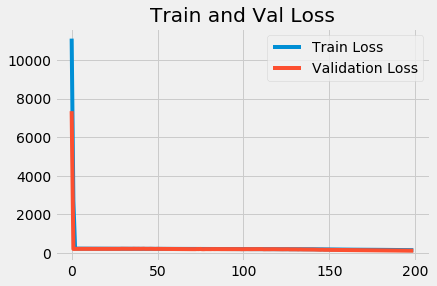

In [10]:
#迭代图像
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(epoch)
plt.plot(epochs_range, loss, label='Train Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Train and Val Loss')
plt.show()

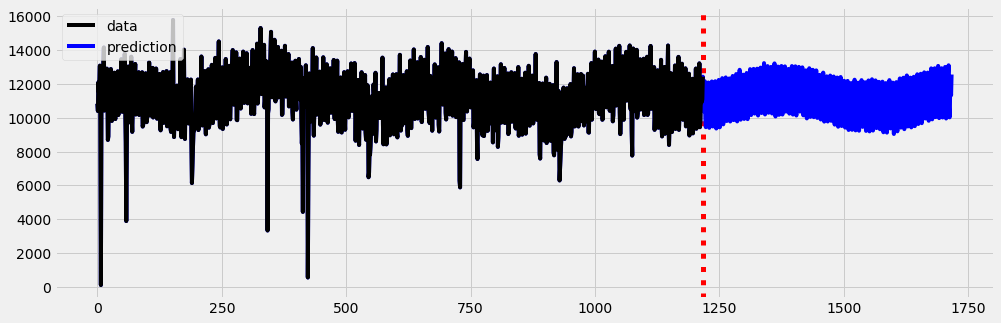

In [11]:
data_times=np.arange(len(data)) #np.arange(起始,終點,間距)
all_data=np.hstack((data,predict)) #np.hstack 沿著水準方向將陣列堆疊起來
predicted_times=np.arange(len(all_data))

plt.figure(figsize=(15, 5))
plt.axvline(len(data), linestyle="dotted", linewidth=5, color='r') #axvline 畫垂直線
predicted_lines = plt.plot(predicted_times, all_data, label="prediction", color="b")
data_lines = plt.plot(data_times, data, label="data", color="k")
plt.legend(handles=[data_lines[0], predicted_lines[0]],loc="upper left")
#为训练，验证，预测数据分别创建图例
plt.show()